# Progettino AQM

# Alla ricerca dell' autovalore dell'hamiltoniana dello stato fondamentale

#### Autori:
Dott. Michele Grossi<br>
Francesco De Luca<br>
Ian Gremese<br>
Carlo Zollo

##### Cose che sarebbe interessante integrare prima della fine
Guardare oltre che le energie anche la forma dei singoli gs <br>
Trovare un modo per misurare le prestazioni <br>
Hardware reale è tanta sbatta <br>
Trovare simmetrie nell'hamiltoniana per ottimizzare ansatz<br>
Riuscire a scrivere circuito associato all'hamiltoniana(come? per quanti gates)?<br>

### Armamentario generale, da caricare prima delle diverse operazioni

#### Diagonalizzazione computazionale "classica"

Codice funzionale alla compilazione delle hamiltoniane da diagonalizzare.

Importiamo operatori e matrici di Pauli

In [1]:
from qiskit.quantum_info.operators import Operator, Pauli

Funzione per la diagonalizzazione classica di una lista di lunghezza variabile di operatori $\hat H$, che ha la forma `([H0, H1, H2, ...], )`.

In [2]:
import numpy as np
from numpy import linalg

def class_par_H_diagonalizer(*H):
    E_l = []
    P_l = []
    Eivals = []
    GSvals = []
    num_qubits = 2

    for k in H[0]: #H is ([H0, H1, ...],), so Hj can be selected as H[0][j]
        E_l, P_l = linalg.eig(k.data)
        E_l = np.real(E_l)
        Eivals.append(np.sort(E_l))
        GSvals.append(np.min(E_l))
        
    return GSvals, Eivals

Funzione per il grafico dei soli valori della diagonalizzazione classica.

In [3]:
import matplotlib.pyplot as plt

def plot_class(lists):

    #plt.rcParams["figure.figsize"] = (20,10)
    fig, ax = plt.subplots(figsize=(9,6), dpi=100)#, fontsize=8)

    plt.xticks(B)

    #ax.scatter(b, energy, marker='o')
    ax.scatter(B, lists[0], marker='o')
    ax.plot(B, lists[1], color="#000000", linewidth=0.5)

    ax.set(xlabel='B field', ylabel='Energy', title='')

    ax.grid()
    plt.show()

#### Diagonalizzazione quantistica con il VQE

Codice per la scrittura delle hamiltoniane da diagonalizzare:

In [4]:
import numpy as np
from numpy import linalg
from qiskit.opflow import X, Y, Z, I, primitive_ops

Funzione che cerca il minimo autovalore dell'hamiltoniana:

In [5]:
from IPython.display import display as ipd_display, clear_output as ipd_clear
from qiskit.algorithms import VQE

def VQE_par_H_diagonalizer(local_vqe,*H):
    
    GSvals = []
    meanerr = []
    
    for i in range(len(H[0])):
        ipd_clear(wait=True)
        ipd_display("%da iterazione di %d"%(i+1,len(H[0])))
    
        local_result = local_vqe.compute_minimum_eigenvalue(H[0][i])
        GSvals.append(np.real(local_result.eigenvalue))
        
        meanerr.append(intermediate_info['stddev'][-1])
    
    ipd_clear(wait=True)
    ipd_display("Finito.")
    return GSvals, meanerr

Funzione per la raccolta di dati relativi all'ottimizzazione del VQE:

In [6]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [7]:
#import matplotlib as mpl
#mpl.rcParams.update({'font.family': 'Linux Libertine', 'text.latex.preamble': r'\usepackage{lmr}',})

Funzione per il grafico dei valori della diagonalizzazione classica e quantistica:

In [81]:
import matplotlib.pyplot as plt

def plot_tot(lists):

    #plt.rcParams["figure.figsize"] = (20,10)
    fig, ax = plt.subplots(figsize=(9,6), dpi=100)

    plt.xticks(B)

    #ax.scatter(b, energy, marker='o')
    ax.scatter(B, lists[0], marker='o')
    ax.plot(B, lists[1], color="#000000", linewidth=0.5)
    
    #itero sulle diverse tecniche che ho utilizzato
    for i in range(2,len(lists)):
        ax.scatter(B, lists[i], marker='x')

    ax.set(xlabel='B field', ylabel='Energy', title='')

    ax.grid()
    plt.show()

## Hamiltoniana n. 2: Interazioni anisotrope fra spin in campo magnetico $B$

$$\hat H = - \sum_{\substack{i,j=1\\i<j}}^n J\left( \hat X^{(i)}\hat X^{(j)} + g_y\hat Y^{(i)}\hat Y^{(j)} + g_z\hat Z^{(i)}\hat Z^{(j)} \right) - B \sum_{i=1}^n Z^{(i)}$$

### Valori dei parametri
Definiamo i valori dei parametri presenti nell'espressione dell'hamiltoniana:

I valori dei parametri dovrebbe passare da un rapporto B/j grande tra termine di campo e spin ( circa 4) ad un rapporto piccolo ( crica 0.1). Circa citando il paper di grossi, Quando il termine di campo è più forte dovremmo tendere ad effetto zeeman, GS tende allo stato con tutti gli spin allineati verso il basso. Quando il termine di spin domina invece ci aspettiamo che il GS sia entanglement di stati con spin su e giu.

In [ ]:
Natoms = 2  ##Il numero di atomi cambierà poi
J = -1
gy = 0.5
gz = 0.
B = np.linspace(-4,0,3).tolist()

### Diagonalizzazione computazionale "classica"

#### Costruzione di $\hat H$
Costruiamo la lista delle hamiltoniane sui diversi valori di B:

In [83]:
import numpy as np
from qiskit.opflow import X, Y, Z, I

##La versione "classica" di questa funzione utilizza Operatori del tipo Operators, che un eigensolver classico può utilizzare


def Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,B):
    
    #Builds the N-atoms Hamiltonian for anisotropic Magnetic field-spin interaction

    #initialize 0-dimensional Operators
    field=Operator([0])
    spin=Operator([0])
    
    #cycle over all qubits
    for i in range(Natoms):
       
        #Adds the spin field interaction for each atom
        field=(field^I)+(B*((I^i)^Z))
        spin=spin^I
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spin += ( J * ((I^j)^X^(I^(i-j-1))^X))
            spin += (J*gy*((I^j)^Y^(I^(i-j-1))^Y))
            spin += (J*gz*((I^j)^Z^(I^(i-j-1))^Z))
            
    return(spin+field)

In [84]:
cH = []
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))

#### Algoritmo per risoluzione classica

Invochiamo la funzione per la diagonalizzazione classica computazionale:

In [ ]:
cGSEigE, EigE = class_par_H_diagonalizer(cH)

Visualizziamo il grafico degli autovalori determinati classicamente:

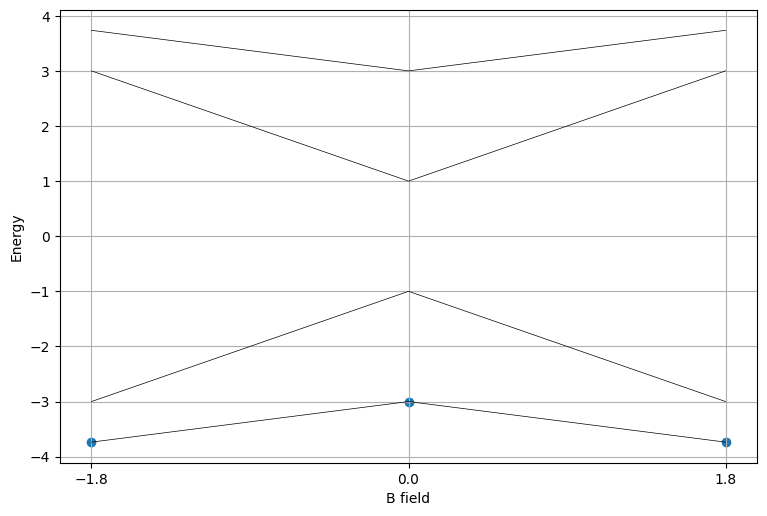

In [87]:
plot_class([cGSEigE, EigE])

Nota: ci interesserebbe anche trovare gli autovettori per avere qualche insight in più su come si potrebbe ottimizzare l'ansatz.

### Diagonalizzazione quantistica con il VQE

#### Costruzione di $\hat H$ Versione quantistica
Costruiamo la lista delle hamiltoniane sui diversi valori di B:

In [ ]:
##La versione quantistica utilizza operatori del tipo PauliOp che è l'unico tipo che l'algoritmo VQE accetta

def Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B):
    
    #Builds the N-atoms Hamiltonian for anisotropic Magnetic field-spin interaction
    #initialize 0-dimensional Operators
    init = primitive_ops.PauliOp(Pauli('I'*Natoms),0)
    field,spins = [init]*2
    
    #cycle over all qubits
    for i in range(Natoms):
    
        #Adds the spin field interaction for each atom
        field += primitive_ops.PauliOp(Pauli('I'*i+'Z'+'I'*(Natoms-i-1)),B)
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spins += primitive_ops.PauliOp(Pauli('I'*j+'X'+'I'*(i-j-1)+'X'+'I'*(Natoms-i-1)),J)
            spins += primitive_ops.PauliOp(Pauli('I'*j+'Y'+'I'*(i-j-1)+'Y'+'I'*(Natoms-i-1)),J*gy)
            spins += primitive_ops.PauliOp(Pauli('I'*j+'Z'+'I'*(i-j-1)+'Z'+'I'*(Natoms-i-1)),J*gz)
    return (field+spins),Operator((field+spins).to_matrix())

In [ ]:
qH = []
for k in range(len(B)):
    ham, checkmat = Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k])
    #print((checkmat - cH[k])) dà sempre 0 se l'hamiltoniana è scritta bene
    qH.append(ham)

#### Algoritmo

Facciamo una scelta dell'ansatz, fra `EfficientSU2` ecc., impostandone i parametri secondo la definizione che abbiamo dato al nostro problema.

### Importante
La scelta di un buon circuito di ansatz è cruciale per rendere l'algoritmo efficiente. Restringere lo spazio di hilbert ad una dimensione più piccola possibile è molto molto importante. EfficientSU2 è un approccio euristico alla faccenda. Forse leggendo l'articolo di Grossi si capirà qualcosa di più. Finora è chiaro che: <br>
-Hamiltoniana commuta con la coniugazione complessa-> Autostati (e quindi GS) sono reali <br>
-Hamiltoniana commuta con (Spin Totale)(x + y +z)^2? <br>
-Hamiltoniana commuta con Spinz?

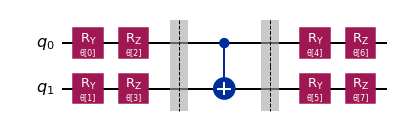

In [90]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

Scegliamo l'ottimizzatore per il VQE fra `SPSA`, `COBYLA` ecc.: 

In [91]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

Costruiamo la funzione per il VQE con ansatz, ottimizzatore, stato iniziale, "quantum instance" e funzione di callback scelti e facciamo eseguire il VQE con i parametri scelti:

In [92]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator

import time

start_time = time.time()


local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

qGSEigE, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

print(time.time()-start_time)

'Finito.'

78.30938076972961


Aggiunto una funzione di time alla VQE per verificare che succede con Ottimizzatori diversi. Non è un indicatore troppo veritiero ma ci da un'idea

Visualizzo stime delle energie dei GS e stime degli errori:

In [53]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-8.102734375 0.22630410389204855
-10.517578125 0.12323049438429862
-11.9359375 0.21962387262379593


Visualizzo il grafico con i risultati classici e della VQE:

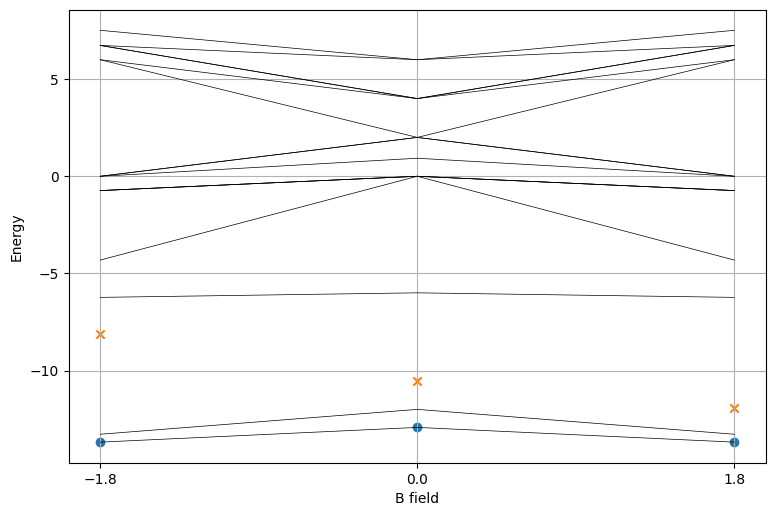

In [54]:
plot_tot([cGSEigE, EigE, qGSEigE])

### Caso con N atomi

Riproviamo come prima con più atomi

In [55]:
cH = []
Natoms=3 #Cambiamo numero atomi

for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))

Sembra che in class_par_H_diagonalizer k.data estragga la matrice sia che sia fatta con opflow sia che sia fatta con la libreria Pauli_operators e quindi funziona comunque

In [56]:
cGSEigE, EigE = class_par_H_diagonalizer(cH)

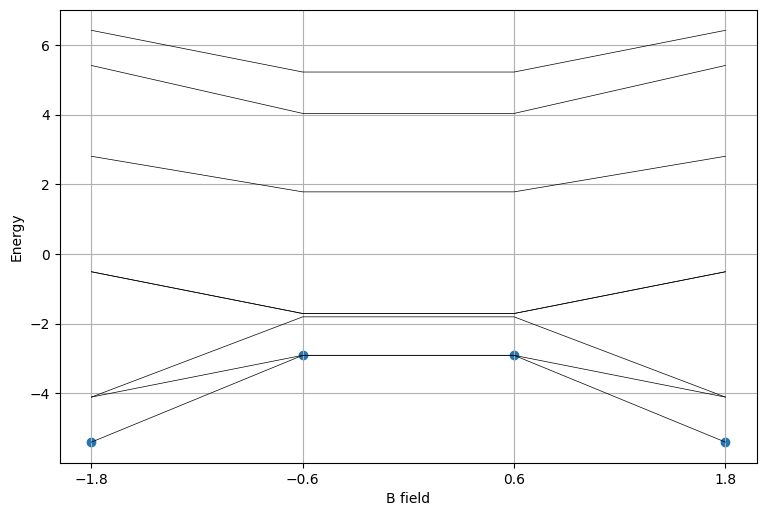

In [57]:
plot_class([cGSEigE, EigE])

In [58]:
qH = []
for k in range(len(B)):
    ham, checkmat = Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k])
    #print((checkmat - cH[k])) dà sempre 0 se l'hamiltoniana è scritta bene
    qH.append(ham)

Ora proviamo a vedere se riusciamo a fare vqe. Prima in locale poi con il runtime (Sui simulatori/Hardware vero dell'IBM)

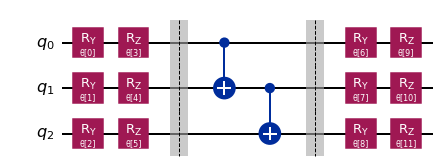

In [59]:
from qiskit.circuit.library import EfficientSU2

num_qubits = Natoms
# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

### Scelta di ottimizzatore vqe

Scegliamo l'ottimizzatore per il VQE fra `SPSA`, `COBYLA` ecc.: 

In [60]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA


maxiter=400 #Numero di iterazioni massime (con 50 nel range tra simmetrico 1.8 converge molto molto poco)

optimizer = SPSA(maxiter=maxiter)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

## Local VQE

Inizializziamo con QasmSimulatorPy, il simulatore locale della vqe. 

In [61]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

Inizializziamo funzioni di callback

In [8]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}


In [71]:
qGSEigE, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

'1a iterazione di 3'

Traceback (most recent call last):
  File "/tmp/ipykernel_59/2040223473.py", line 1, in <module>
    qGSEigE, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)
  File "/tmp/ipykernel_59/2850192642.py", line 13, in VQE_par_H_diagonalizer
    local_result = local_vqe.compute_minimum_eigenvalue(H[0][i])
  File "/opt/conda/lib/python3.8/site-packages/qiskit/algorithms/minimum_eigen_solvers/vqe.py", line 500, in compute_minimum_eigenvalue
    initial_point = _validate_initial_point(self.initial_point, self.ansatz)
  File "/opt/conda/lib/python3.8/site-packages/qiskit/algorithms/minimum_eigen_solvers/vqe.py", line 779, in _validate_initial_point
    raise ValueError(
ValueError: The dimension of the initial point (12) does not match the number of parameters in the circuit (8).

Use %tb to get the full traceback.


In [72]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-5.402929687500001 0.08846957823784392
-2.8832031250000005 0.013125086511599306
-2.9111718750000004 0.0011713026556435158
-5.3309765625 0.08982455241719264


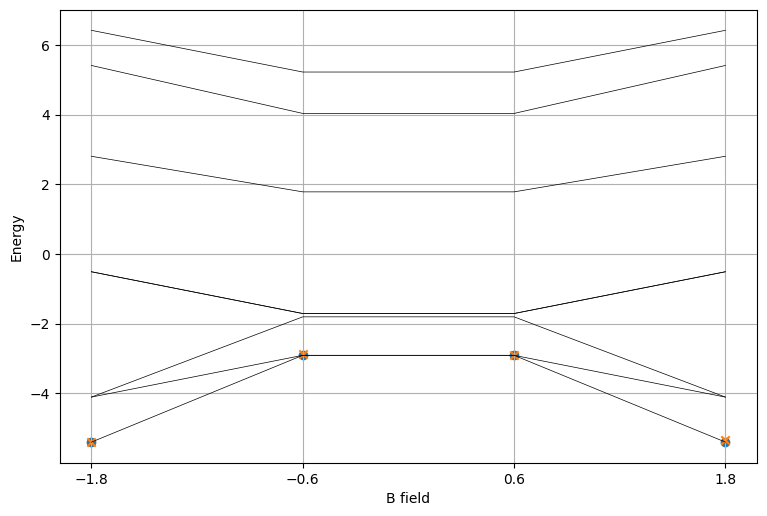

In [65]:
plot_tot([cGSEigE, EigE, qGSEigE])

Visualizzo il grafico con i risultati classici e della VQE: Strano, tutte le energie di vqe sono abbastanza sicure di essere sotto il gs. Proviamo a controllare hce le hamiltoniane siano uguali:

In [66]:
for k in range(len(B)):
    print(np.nonzero((Operator(qH[k])-cH[k])))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


## Runtime VQE


Proviamo con Hardware reale

In [85]:
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.models import BackendProperties
from qiskit.providers.aer import noise

from qiskit.tools.monitor import job_monitor
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit import IBMQ
from qiskit import Aer
from qiskit.utils import QuantumInstance

from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

### Inizializzazione

### Cose account etc etc

In [72]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

ibmqfactory.load_account:WARNING:2022-01-11 16:52:45,955: Credentials are already in use. The existing account in the session will be replaced.


In [87]:

Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

Bisogna scegliere il Backend con meno coda e con un numero sufficiente di qubit.

In [74]:
##backend = provider.get_backend('ibmq_bogota') backend = Aer.get_backend("qasm_simulator")

Resettiamo funzioni di callback

In [104]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

### Numero Shots, Rumore etc

Qui dobbiamo scegliere quanti shot usare e quale ottimizzatore usare, le tolleranze ed il resto.

In [116]:
nShots = 8192
optimizer = COBYLA(maxiter=50, tol=0.001, rhobeg=1.0) #SPSA(maxiter=100, blocking=False, allowed_increase=None, trust_region=False, learning_rate=None, perturbation=None, last_avg=1, resamplings=1, perturbation_dims=None, second_order=False, regularization=None, hessian_delay=0, lse_solver=None, initial_hessian=None, callback=None, termination_checker=None)


Mitigazione dell'errore sì!

In [117]:
measurement_error_mitigation = True

### Runtime con Simulatore (Qasm)

Scegliamo il simulatore

In [118]:
backend = Aer.get_backend("qasm_simulator") 

### Noiseless Simulator

In [119]:
seed = 170  ###Un seed che vale 170 per qualche motivo misterioso?
backend = Aer.get_backend('qasm_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

##counts = []
#values = []
#def store_intermediate_result(eval_count, parameters, mean, std):
#    counts.append(eval_count)
#    values.append(mean)

qasm_vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=qi, initial_point=initial_point,
                         callback=callback) #vqe = VQE(ansatz, optimizer=optimizer, callback=store_intermediate_result, quantum_instance=qi)
#result = vqe.compute_minimum_eigenvalue(operator=H2_op)
#print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
#print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

In [120]:
qGSEigE, meanerr = VQE_par_H_diagonalizer(qasm_vqe,qH)

'Finito.'

In [114]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-5.108124999999999 0.09639426362443049
-2.6195312500000005 0.04529232529696783
-2.8899609375 0.012988286011200226
-5.205976562500001 0.0970613306982814


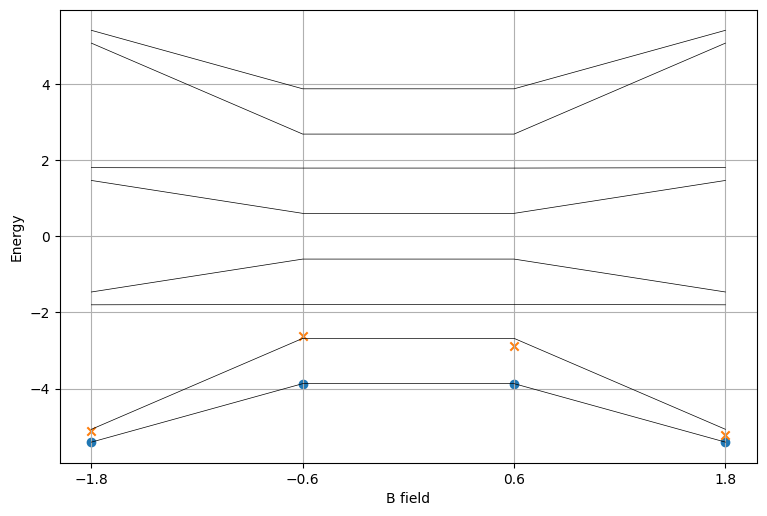

In [115]:
plot_tot([cGSEigE, EigE, qGSEigE])

### Runtime con HW reale

#### La coda per l'hardware reale è lunga e dolorosa. Prima di eseguire codice su macchina accertiamoci sia buono con il simulatore qasssmmmm!!! 

Resettiamo i CallBack

In [111]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

Facciamo andare la VQE RUNTIME!

In [121]:
from qiskit_nature.runtime import VQEClient



runtime_vqe = VQEClient(ansatz=ansatz,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=backend,
                         shots=nShots,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=callback)

In [122]:
qGSEigE, meanerr = VQE_par_H_diagonalizer(runtime_vqe,qH)

'1a iterazione di 4'

Traceback (most recent call last):
  File "/tmp/ipykernel_91/914597976.py", line 1, in <module>
    qGSEigE, meanerr = VQE_par_H_diagonalizer(runtime_vqe,qH)
  File "/tmp/ipykernel_91/2850192642.py", line 13, in VQE_par_H_diagonalizer
    local_result = local_vqe.compute_minimum_eigenvalue(H[0][i])
  File "/opt/conda/lib/python3.8/site-packages/qiskit_nature/runtime/vqe_client.py", line 279, in compute_minimum_eigenvalue
    job = self.provider.runtime.run(
  File "/opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/runtime/ibm_runtime_service.py", line 280, in run
    response = self._api_client.program_run(program_id=program_id,
  File "/opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/api/clients/runtime.py", line 128, in program_run
    return self.api.program_run(program_id=program_id, hub=credentials.hub,
  File "/opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/api/rest/runtime.py", line 144, in program_run
    return self.session.post(url, data=da

In [102]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-5.108124999999999 0.09639426362443049
-2.6195312500000005 0.04529232529696783
-2.8899609375 0.012988286011200226
-5.205976562500001 0.0970613306982814


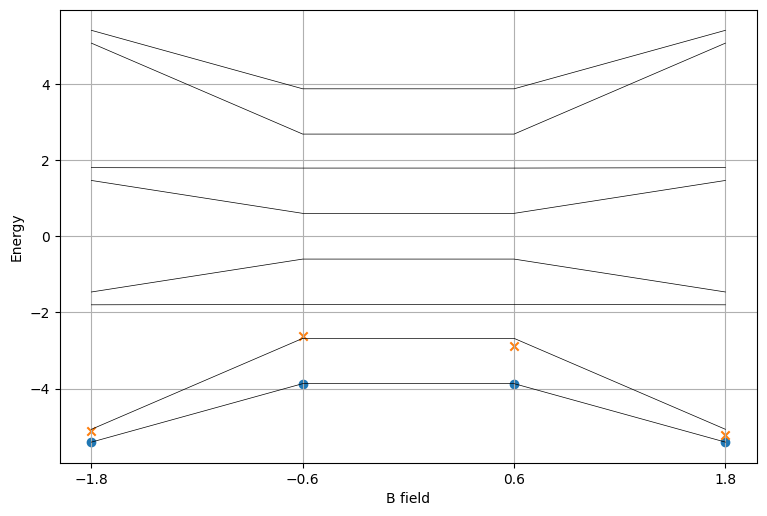

In [103]:
plot_tot([cGSEigE, EigE, qGSEigE])